## **Trying to Implement dcGAN using PyTorch**: _Pokemon Dataset_
---

In [1]:
## Imports 
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageFile
import glob
import os 
import torch
import torch.nn as nn
from torch import Tensor
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from torch.autograd import Variable


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

So before we dive into the DCGAN pipeline, lets first create a suitable dataset path and since we're not going to generate in classified way, we will first load all the images and normalize them before processing 

In [3]:
pokemon_data_path = "/kaggle/input/pokemonclassification/PokemonData"

#@ Collecting only jpg, jpng and png files from the dataset
image_files = glob.glob(os.path.join(pokemon_data_path, "*", "*.jpg")) + \
              glob.glob(os.path.join(pokemon_data_path, "*", "*.jpeg")) + \
              glob.glob(os.path.join(pokemon_data_path, "*", "*.png"))

print(f"Total images found: {len(image_files)}")

Total images found: 6820


In [4]:
#@ Preprocessing the data:

### Normalizing the RGB data after resizing them
transform = transforms.Compose([
    transforms.Resize((64,64)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) 
])

### The custom class for Pokemon images:
class PokemonDataset(Dataset):
    def __init__(self, image_files, transform= None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

## Creating the dataset and DataLoader:
pokemon_dataset = PokemonDataset(image_files, transform= transform)
dataloader = DataLoader(pokemon_dataset, batch_size= 128, shuffle= True, num_workers=4, pin_memory=True)

In [5]:
##@ Checking the sample
data_iter = iter(dataloader)
images= next(data_iter)
print(f"Batch shape: {images.shape}")

Batch shape: torch.Size([128, 3, 64, 64])


- Batch_size= 128
- Number_of_channels= 3
- height = 64
- width= 64

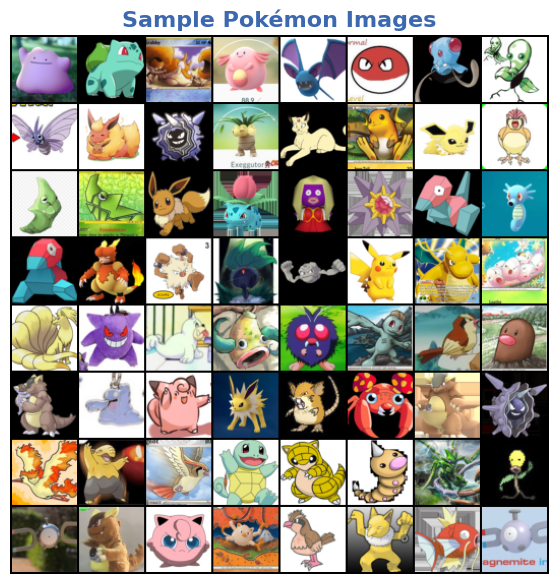

In [6]:
##@ Lets as well as visualize the images loaded

grid = vutils.make_grid(images[:64], nrow= 8, normalize= True)
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Sample Pokémon Images", fontsize=16, color='#3c68b0', fontweight='bold', loc='center')
plt.show()

### Creating the Architecture
---

Defining all the required hyperparameters first.

In [7]:
##@ Hyperparameters:

nz= 100
ngf = 64 ##! Generator feature maps
ndf = 64 ##! Discriminator feature maps
nc= 3

kernel_size = 4

## Training parameters
batch_size= 128
lr= 0.0002  #Authors found that 0.001 was too high 
beta1= 0.5 
beta2 = 0.999
num_epochs = 100
sample_interval = 500

#### 1. Creating the Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, kernel_size, 1, 0, bias= False),
            nn.BatchNorm2d(ngf*8), 
            nn.ReLU(inplace= True), 
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ngf*4), 
            nn.ReLU(inplace= True), 
            nn.ConvTranspose2d(ngf*4, ngf* 2, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ngf*2), 
            nn.ReLU(inplace= True), 
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ngf), 
            nn.ReLU(inplace= True), 
            nn.ConvTranspose2d(ngf, nc, kernel_size, 2, 1, bias= False), 
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

#### 2. Creating the Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()

        self.main= nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size, 2, 1, bias= False), 
            nn.LeakyReLU(0.2, inplace= True), 
            nn.Conv2d(ndf, ndf*2, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ndf*2), 
            nn.LeakyReLU(0.2, inplace= True), 
            nn.Conv2d(ndf*2, ndf*4, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ndf*4), 
            nn.LeakyReLU(0.2, inplace= True), 
            nn.Conv2d(ndf*4, ndf*8, kernel_size, 2, 1, bias= False), 
            nn.BatchNorm2d(ndf*8), 
            nn.LeakyReLU(0.2, inplace= True), 
            nn.Conv2d(ndf*8, 1, kernel_size, 1, 0, bias= False), 
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

#### 3. Loss Function

In [10]:
adversarial_loss = torch.nn.BCELoss()

#### 4. Initialization

In [11]:
##@  Initializing generator and discriminator
generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator(nc, ndf).to(device)

print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### 5. Optimization

In [12]:
fixed_noise= torch.randn(64, nz, 1,1, device= device)

optimizer_g= torch.optim.Adam(generator.parameters(), lr= lr, betas=(beta1, beta2))
optimizer_d= torch.optim.Adam(discriminator.parameters(), lr= lr, betas=(beta1, beta2))

#### 6. Training Loop

In [13]:
#@ Directory to save the generated images
if os.path.exists('dc_images'):
  shutil.rmtree('dc_images')   ## will delete the directory and its contents
os.makedirs("dc_images", exist_ok= True)

In [14]:
print("Starting training ....")

for epoch in range(num_epochs):
    for i, imgs in enumerate(dataloader):

        # Adversarial ground truths (real and fake labels)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0).to(device), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0).to(device), requires_grad=False)

        # Configure input
        real_imgs = imgs.to(device)  # Move real images directly to device

        # --- Training the Generator ---
        optimizer_g.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.size(0), nz, 1, 1)))).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs).view(-1, 1), valid)

        g_loss.backward()
        optimizer_g.step()

        # --- Training the Discriminator ---
        optimizer_d.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs).view(-1, 1), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).view(-1, 1), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_d.step()

        # Print training progress
        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch + 1, num_epochs, i + 1, len(dataloader), d_loss.item(), g_loss.item())
        # )
        ## Commenting out the print so that it takes lesser time to save in kaggle as well as it makes notebook clean

        # Save generated samples only for batch 0 of each epoch
        if i == 0:  # Only save for the first batch of each epoch
            save_image(gen_imgs.data[:25], f"dc_images/epoch_{epoch}_batch_{i}.png", nrow=5, normalize=True)


Starting training ....


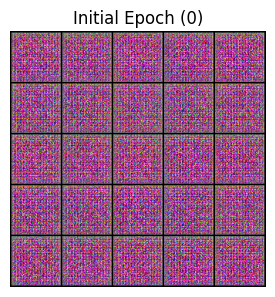

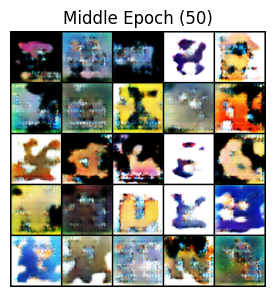

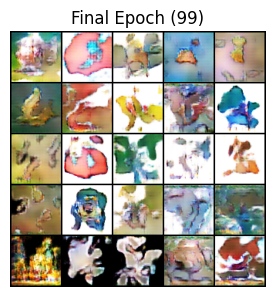

In [15]:
#@ Viewing the generated outputs progressments
initial_path = f"dc_images/epoch_0_batch_0.png"
middle_path = f"dc_images/epoch_{num_epochs // 2}_batch_0.png"
final_path = f"dc_images/epoch_{num_epochs-1}_batch_0.png"

# Function to load and display an image from a file path
def show_image(image_path, title="Image"):
    if os.path.exists(image_path):
        img = mpimg.imread(image_path)
        
        # Dynamically adjust the figure size based on the image's shape
        height, width, _ = img.shape
        plt.figure(figsize=(width / 100, height / 100))  # Adjust size based on image dimensions
        
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")  # Remove axes for better visualization
        plt.show()
    else:
        print(f"Image not found: {image_path}")

# Display initial, middle, and final images
show_image(initial_path, title="Initial Epoch (0)")
show_image(middle_path, title=f"Middle Epoch ({num_epochs // 2})")
show_image(final_path, title=f"Final Epoch ({num_epochs - 1})")

Well, it seems like it's working.. 🤷‍♂️